# Project 4: Weakly-supervised segmentation with boxes
# Implement Yolo v1 algorithm from Scratch
### Yulin Xue
### y79xue@uwaterloo.ca

**Abstract:**

Yolo is a fast and powful algorithm using convolutional neural network(CNN) to detect and identify multiple object. Yolo algorithm seperates the object detection problem into bounding boxes and classification problems. Yolo divides the image into grid cells(7x7 here) and each cell contains the two bounding boxes and their class probabilities. At the end, only one bounding box with the highest probability will be produced in the end.

The advantages of Yolo algorithm are fast and the cost of human supervision is about 1 sec. Since Yolo does not require pixel-level segmentation accuracy. The cost of creating the bounding boxes and classifying is not expensive.

The disadvantage is that when objects are mixed, the bounding box can become a bit messy. Also, in the first version of Yolo, each bounding box can only contain one object. Of course this can be solved by adjusting the Neural Network, but this is beyond the scope of the project.

<img src="images/yolo_sample.png" width="500" height="500"> 

**Code Libraries:**

1. extlibs.dataset.VOCDataset:

a function to load and preprocess the dataset, converting the images and labels into a tensor. Created cells based on the number of split_size and the bounding box in cells. 

2. extlibs.utils.cellboxes_to_boxes:

Collect all the boxes from each cell, by using the prediction(model(x))

3. extlibs.utils.non_max_suppression:
There are 49 bounding boxes(split_size*split_size), which will make the result very messy and most of them are wrong. Thus, I imported non_max_suppression function to remove the bounding boxes that might be in error with a threshold.

Function above is from https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/object_detection/YOLO

**Agenda**
1. Build Neural Network for Yolo
2. Loss Function
3. Some helper function
4. Start Train a overfilt model and a well-trained model
5. Discussion

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.transforms.functional as FT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

from extlibs.dataset import VOCDataset
from extlibs.utils import non_max_suppression,cellboxes_to_boxes

# 1. Let's build the Neural Network for Yolo!
The general architecture will follow the paper as below, but there will be some minor changes.

<img src="images/yolo_nn.png" width="500" height="500"> 

## a. Calculate the padding
Since the paper does not mention the size of the padding, we need to calculate the padding of each layer before we start. 

$$\text{Output} = \frac{\text{Input}−\text{kernal}+2*\text{padding}}{\text{stride}}+1$$

By using the formula above, we can calculate the padding for the first block, with layer1 of input_size=448, output_size=112, kernal=7, stride=2 and layer2 of kernal=2, stride=2. 

Note: the division here is floor division

$$o_1 = \frac{448-7+2p}{2} + 1 = 221 + p$$
$$112 = \frac{221+p-2}{2} + 1$$

Thus we can get that p=3

## b. Batch Norm
The architecture from the paper does not include batch norm, because batch norm was not invented or popular when the paper is published. Batch norm is a network layer between two hidden layer and is responsible for normalizing the value of each activation feature vector. Batch norm is a very popular method to improve the performance in Neural Network nowadays. Thus, I am going to include batch norm in our structure.

## c. Fully connected layer
In the paper, the last two layer are fully connected linear layer, which will take a very long time to run and require a very large amount of memory. To simplify, I am going to use only 400 neurons.

## d. Neural Network Model

In [2]:
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, split_size=7, num_boxes=2, num_classes=20):
        super(Yolov1, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            # Init in_channels = 3, since rgb
            # Block 1
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2,2)),

            # Block 2
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2,2)),

            # Block 3
            nn.Conv2d(192, 128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2,2)),

            # Block 4
            nn.Conv2d(512, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),

            nn.Conv2d(512, 512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2,2)),

            # Block 5
            nn.Conv2d(1024, 512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),

            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),

            # Block 6
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),

            # Block 7
            # nn.Flatten(),
            # nn.Linear(1024 * split_size**2, 4096),
            # nn.Dropout(0.0),
            # nn.LeakyReLU(0.1),
            # nn.Linear(4096, split_size**2 * (num_classes + num_boxes*5))

            nn.Flatten(),
            nn.Linear(1024 * split_size**2, 400),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(400, split_size**2 * (num_classes + num_boxes*5))
        )
      
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

# 2. Loss Function
The loss function in Yolo is much more complicated than pixel-level segmentation algorithm. Because we need to consider which bounding box to choose, the coordinate, the size, whether it contains an object and the label. 

The structure of prediction can be found as follows, which will be very useful when we develop the loss function.

**Note 1:** x,y here is the midpoint of the bounding box.

**Note 2:** w,h is the ratio of the width and height of the cells. (e.g. when w = 1, the width of the bounding box is the same as the width of the cell.

**Note 3:** w and h can be greater than 1, which means the bounding box can be larger than the cell.

<img src="images/pred_look.png" width="500" height="500"> 


In [3]:
mse = nn.MSELoss(reduction='sum')

## a. find better box
During the training process, Yolo generates two bounding boxes in each cell. We need to define a function to determine which bounding box is better. Thus, we need to calculate the IoU between two predicted bounding boxes and target bounding box, the predicted bounding box with higher IoU is better. 

The area of the intersection can be calculated as followed:

<img src="images/find_better_box.png" width="500" height="500"> 

The area of the union can be calculated as the formula below:

$$\text{union} = \text{box1_area} + \text{box2_area} - \text{intersection}$$

In [4]:
def get_margin_box(box):
    """
    Input: a tensor of(midpoint x, midpoint y, width, hight)
    Return: a tensor of the four coordinate of the box(left_x, right_x, top_y, bot_y)
    """
    mid_x = box[..., 0:1]
    mid_y = box[..., 1:2]
    half_width = box[..., 2:3] / 2
    half_height = box[..., 3:4] / 2
    
    left_x = mid_x - half_width
    right_x = mid_x + half_width
    top_y = mid_y - half_height
    bot_y = mid_y + half_height
    
    return left_x, right_x, top_y, bot_y

def IoU(left_x1, right_x1, top_y1, bot_y1, left_x2, right_x2, top_y2, bot_y2):
    """
    Calculate the IoU between one predicted box and target box
    """
    left_x_inte = torch.max(left_x1, left_x2)
    right_x_inte = torch.min(right_x1, right_x2)
    top_y_inte = torch.max(top_y1, top_y2)
    bot_y_inte = torch.min(bot_y1, bot_y2)
    
    # The area will be 0, if x2 - x1 < 0, since area cannot be negative
    intersection = (right_x_inte - left_x_inte).clamp(0) * (bot_y_inte - top_y_inte).clamp(0)
    box1_area = abs((right_x1 - left_x1) * (bot_y1 - top_y1))
    box2_area = abs((right_x2 - left_x2) * (bot_y2 - top_y2))
    
    union = box1_area + box2_area - intersection + 1e-6   # Need to be greated than 0
    return intersection/union
    

def find_better_box(pred, target):
    """
    In Yolo Algorithm, there are two bounding boxes in each cell, we need to find the better one
    The one with higher IoU is better
    Return: index (shape: split_size, split_size), indicate the better bounding box in S^2 cell
    """
    left_x1, right_x1, top_y1, bot_y1 = get_margin_box(pred[..., 21:25])
    left_x2, right_x2, top_y2, bot_y2 = get_margin_box(pred[..., 26:30])
    left_x_target, right_x_target, top_y_target, bot_y_target = get_margin_box(target[..., 21:25])
    
    iou1 = IoU(left_x1, right_x1, top_y1, bot_y1, left_x_target, right_x_target, top_y_target, bot_y_target)
    iou2 = IoU(left_x2, right_x2, top_y2, bot_y2, left_x_target, right_x_target, top_y_target, bot_y_target)
    
    ious = torch.cat([iou1.unsqueeze(3), iou2.unsqueeze(3)], dim=3)
    return torch.argmax(ious, dim=3)

## b. Loss function: Coordinates of boxes
Ideally, we hope the center(midpoint_x, midpoint_y) of our predicted bounding box to be as close as possible to the center of the target. 

**Note:** we only penalizes the coordinates error of the bounding box responsible for prediction(higher IoU).

Thus, we can develop a Loss function as follow:

$$L_{coord} = \sum_{i=0}^{S^2} \sum_{j=0}^B I_{ij}^{obj} [(x_i - \hat x_i)^2) + (y_i - \hat y_i)^2]$$

In [5]:
# Loss: Coordinates of boxes
def loss_coord(pred, target, exists_box, better_box):
    pred = exists_box * (better_box * pred[..., 26:28] + (1-better_box) * pred[..., 21:23])
    target = exists_box * target[..., 21:23]
    return mse(pred, target)

## c. Loss function: Size of boxes
Also, we want the size(width, height) of our predicted box to be close to the target's box.

**Note 1:** Same as before, only penalizes the bounding box with higher IoU

**Note 2:** We are going to take the square root of width and height. Otherwise, the predicted bounding box tends to take a smaller width and height under the same error.

**Note 3:** $\hat w$ or $\hat h$ may be negative, since there are no restrictions, while $w$ and $h$ are always positive. Thus, we need to be careful when we take the square root

Thus, we can develop a Loss function as follow:

$$L_{size} = \sum_{i=0}^{S^2} \sum_{j=0}^B I_{ij}^{obj} [(\sqrt w_i - \sqrt {\hat w_i})^2 + (\sqrt h_i - \sqrt {\hat h_i})^2]$$

In [6]:
# Loss: Size of boxes
def loss_size(pred, target, exists_box, better_box):
    pred = exists_box * (better_box * pred[..., 28:30] + (1-better_box) * pred[..., 23:25])
    target = exists_box * target[..., 23:25]
#     pred = torch.sqrt(pred.clamp(1e-6))
    pred = torch.sign(pred) * torch.sqrt(torch.abs(pred) + 1e-6)
    target = torch.sqrt(target)
    return mse(pred, target)

## d. Loss function: Prob of containing object
Here we are going to develop a loss function that includes the probability of containing the object. The target is either 0 or 1(without object and with object). The predicted value is the probability of containing an object.

**Note:** Same as before, only penalizes the bounding box with higher IoU.

$$L_{obj} = \sum_{i=0}^{S^2} \sum_{j=0}^B I_{ij}^{obj} 
(C_i - \hat C_i)^2$$

In [7]:
# Loss: Prob of containing object
def loss_object(pred, target, exists_box, better_box):
    pred = exists_box * (better_box * pred[..., 25:26] + (1-better_box) * pred[..., 20:21])
    target = exists_box * target[..., 20:21]
    return mse(pred, target)

## e. Loss function: Prob of not containing object
If there is no object in the target bounding box, but the predicted bounding box think consider that there is a high probability of an object in the bounding box. We also penalize such cases.

**Note:** It does not mention in the paper, but only penalize the better bounding box produces the bad result. After my experiment and research, I think we should consider both of the bounding boxes here. The reason is that there is only one object in each bounding box. In the previous case, we only need to consider the bounding box with higher IoU, since each cell will only produce one bounding box at the end. However, there is no reason that we do not penalize both of the bounding boxes, if they believe they contain an object when they are not.

$$L_{no\_obj} = \sum_{i=0}^{S^2} \sum_{j=0}^B I_{ij}^{no\_obj} (C_i - \hat C_i)^2$$

<table><tr>
<td> <img src="images/bad_result_no_object.png" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="images/good_result_no_object.png" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>
$$\text{Penalize one bounding box vs Penalize both bounding boxes}$$

In [8]:
# Loss function: Prob of not containing object(Penalize both bounding boxes)
def loss_no_object(pred, target, exists_box, better_box):
    pred1 = (1-exists_box) * pred[..., 20:21]
    pred2 = (1-exists_box) * pred[..., 25:26]
    target = (1-exists_box) * target[..., 20:21]
    return mse(pred1, target) + mse(pred2, target)

# Loss function: Prob of not containing object(Penalize better bounding boxes)
# def bad_loss_no_object(pred, target, exists_box, better_box):
#     pred = (1-exists_box) * (better_box * pred[..., 25:26] + (1-better_box) * pred[..., 20:21])
#     target = (1-exists_box) * target
#     return mse(pred, target)

## f. Loss function: classification
Here, a loss function is developed to ensure that the bounding box correctly predicts what object is inside.

**Note:** Same as before, only penalizes the bounding box with higher IoU.

$$L_{class} = \sum_{i=0}^{S^2} I_{ij}^{obj} \sum_{c\in classes} (p_i(c) - \hat p_i(c))^2$$

In [9]:
# Loss: Prob of each class
def loss_class(pred, target, exists_box, better_box):
    pred = exists_box * pred[..., :20]
    target = exists_box * target[..., :20]
    return mse(pred, target)

## g. YoloLoss
Now, let's put everything together as a loss function for the Yolo model.

**Note:** There are two hyperparameter $\lambda_{coord}$ and $\lambda_{no\_obj}$ can be fine-tuned to develop a better result for different dataset. Here, we will use the values from the paper where $\lambda_{coord} = 5$ and $\lambda_{no\_obj} = 0.5$

$$L = \lambda_{coord} ( L_{coord} + L_{size} ) + L_{obj} + \lambda_{no\_obj} L_{no\_obj} + L_{class}$$

In [10]:
class YoloLoss(nn.Module):
    def __init__(self, split_size=7, num_boxes=2, num_classes=20):
        super(YoloLoss, self).__init__()
        self.split = split_size
        self.boxes = num_boxes
        self.classes = num_classes

        # Parameter from Yolo paper
        self.lambda_coord = 5
        self.lambda_noobj = 0.5

    def forward(self, pred, target):
        # Reshape as (BatchSize, 7, 7, 20+5*2)
        pred = pred.reshape(-1, self.split, self.split, self.classes + self.boxes * 5)
        better_box = find_better_box(pred, target)
        exists_box = target[..., 20:21]    # Whether the correspoing cell contains the object
        
        coord_loss = loss_coord(pred, target, exists_box, better_box)
        size_loss = loss_size(pred, target, exists_box, better_box)
        object_loss = loss_object(pred, target, exists_box, better_box)
        # no_object_loss = bad_loss_no_object(pred, target, exists_box, better_box)
        no_object_loss = loss_no_object(pred, target, exists_box, better_box)
        class_loss = loss_class(pred, target, exists_box, better_box)
    
        loss = self.lambda_coord * (coord_loss + size_loss) + object_loss + self.lambda_noobj * no_object_loss + class_loss
        
        return loss

# 3. Some helper function

## a. Transform
Here I only apply some basic transforms: resize and transform to tensor. In the original paper, the training dataset is increased by transforms such as mirroring, blurring and etc. Due to the limitations of the hardware, I am not going to implement this, because the training set is enough for me.

In [11]:
# This class composes transofrmations from a given list of image transforms (expected in the argument). Such compositions 
# will be applied to the dataset during training. This cell is fully implemented.
class JointCompose(object):
    def __init__(self, transforms):
        """
        params: 
           transforms (list) : list of transforms
        """
        self.transforms = transforms

    # We override the __call__ function such that this class can be
    # called as a function i.e. JointCompose(transforms)(img, target)
    # Such classes are known as "functors"
    def __call__(self, img, target):
        """
        params:
            img (PIL.Image)    : input image
            target (PIL.Image) : ground truth label 
        """
        for t in self.transforms:
            img, target = t(img), target
        return img, target
    
transform = JointCompose([transforms.Resize((448, 448)), transforms.ToTensor(),])

## b. Train function

In [24]:
# DEVICE = "cpu"
DEVICE = "cuda"  # Can switch to GPU by simply uncomment this line

def train(dataloader, model, optimizer, loss_fn):
    sum_loss = 0

    pbar = tqdm(dataloader, leave = False)
    for batch, (x, y) in enumerate(pbar):
        # One Batch
        x, y = x.to(DEVICE), y.to(DEVICE)
        pred = model(x)
        loss = loss_fn(pred, y)
        sum_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#         pbar.set_description("Loss: {:.2f}".format(loss))

    return sum_loss / (batch+1)

## c. Test function

In [25]:
def test(dataloader, model, optimizer, loss_fn):
    sum_loss = 0

    pbar = tqdm(dataloader, leave = False)

    with torch.no_grad():
        for batch, (x, y) in enumerate(pbar):
            # One Batch
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred = model(x)
            loss = loss_fn(pred, y)
            sum_loss += loss.item()
        
#         pbar.set_description("Loss: {:.2f}".format(loss))

    return sum_loss / (batch+1)

## d. Develop a function to plot the bounding box, predicted label and predicted probability

In [26]:
LABEL = ["airplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "dining table",
"dog", "horse", "motorbike", "person", "potted plant", "sheep", "sofa", "train", "TV monitor"]
LABEL_COLOR = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', 
               '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
               '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def plot_image(image, boxes, ax):
    im = np.array(image)
    height, width, _ = im.shape
    ax.imshow(im)

    for box in boxes:
        obj = int(box[0])
        prob = box[1]
        
        # Some projection
        prob = max(0, min(1, prob))

        topleft_x = box[2] - box[4] / 2
        topleft_y = box[3] - box[5] / 2
        rect = patches.Rectangle(
            (topleft_x * width, topleft_y * height),
            box[4] * width,
            box[5] * height,
            linewidth=2,
            edgecolor=LABEL_COLOR[obj],
            facecolor="none",
        )
        ax.annotate('{}: {:.2f}'.format(LABEL[obj], prob), 
                    (topleft_x * width+5, topleft_y * height-10), 
                    backgroundcolor=LABEL_COLOR[obj])
        ax.add_patch(rect)

# 4. Start Training

In [27]:
# Some Hyperparameters
seed = 684
torch.manual_seed(seed)

LEARNING_RATE = 2e-5
BATCH_SIZE = 16 # 64 in original paper
WEIGHT_DECAY = 0.0005
EPOCHS = 10
IMG_DIR = "PASCAL_VOC/images"
LABEL_DIR = "PASCAL_VOC/labels"

In [28]:
# Load Dataset
small_train_dataset = VOCDataset("PASCAL_VOC/1examples.csv", transform=transform,img_dir=IMG_DIR,label_dir=LABEL_DIR)
large_train_dataset = VOCDataset("PASCAL_VOC/train.csv", transform=transform,img_dir=IMG_DIR,label_dir=LABEL_DIR)
test_dataset = VOCDataset("PASCAL_VOC/test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR)

small_train_loader = DataLoader(dataset=small_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
large_train_loader = DataLoader(dataset=large_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## a. Create overfit_model and train it on the single image dataset.

**Note 1:** It only takes 30 sec with CPU.

**Note 2:** There is only 1 image in overfit training dataset

**Note 3:** There are 368 images in the test dataset

In [ ]:
%matplotlib notebook

overfit_model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
optimizer = torch.optim.Adam(overfit_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = YoloLoss()

overfit_loss = []
pbar = tqdm(range(EPOCHS))
for epoch in pbar:
    loss = train(small_train_loader, overfit_model, optimizer, loss_fn)
    overfit_loss.append(loss)
#     pbar.set_description("{:8s}: {:.2f}".format("Avg Loss", loss))

In [ ]:
pbar = tqdm(range(1))
for epoch in pbar:
    overfit_loss_test = test(test_loader, overfit_model, optimizer, loss_fn)

### (i) Yolo Loss in training dataset
It can be seen that the Yolo loss decreases rapidly in the overfitted model.

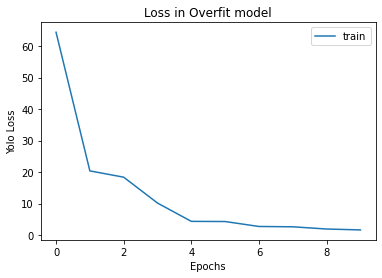

In [31]:
%matplotlib inline

plt.plot(overfit_loss, label="train")
# plt.axhline(y=overfit_loss_test, label="test", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Yolo Loss")
plt.title("Loss in Overfit model")
plt.legend()
plt.show()

### (ii) Yolo Loss in test dataset
The loss in training set after 10 Epochs is only 1.66 while the loss in test dataset is 1086.05. This is to be expected, as the model over-fits the only image seen

In [32]:
print("The loss in training set is {:.2f} while the loss in test set is {:.2f}".format(overfit_loss[-1], overfit_loss_test))

The loss in training set is 1.66 while the loss in test set is 1086.05


### (iii) Visual result
As can be seen below, the overfitting model performs very well on the only image seen. The model was 100% confident in predicting that the object was a car, which was correct and the size of bounding box is very close.

However, the performance on the unseen image is poor. The predicted object is wrong and the bounding box is weird

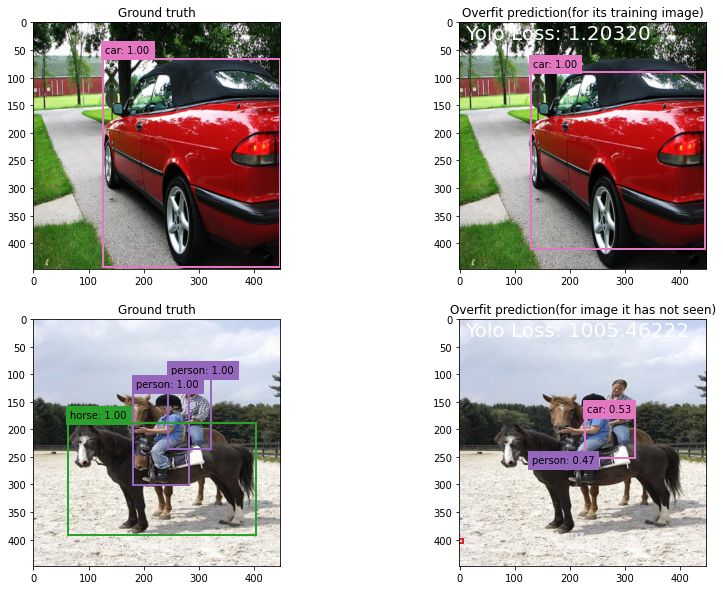

In [36]:
fig = plt.figure(figsize=(14,10))

for x, y in small_train_loader:
    for i in range(1):
        ax1 = fig.add_subplot(2,2,1)
        plt.title("Ground truth")
        x, y = x.to(DEVICE), y.to(DEVICE)
        bboxes = cellboxes_to_boxes(y)
        bboxes = non_max_suppression(bboxes[i], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        plot_image(x[i].permute(1,2,0).to("cpu"), bboxes, ax1)
        
        ax2 = fig.add_subplot(2,2,2)
        plt.title("Overfit prediction(for its training image)")
        bboxes = cellboxes_to_boxes(overfit_model(x))
        bboxes = non_max_suppression(bboxes[i], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        plot_image(x[i].permute(1,2,0).to("cpu"), bboxes, ax2)

    pred = overfit_model(x)
    loss = loss_fn(pred, y)
    ax2.text(10, 30, 'Yolo Loss: {:.5f}'.format(loss.item()), fontsize=20, color='white')
    break


for x, y in test_loader:
    for i in range(1):
        ax3 = fig.add_subplot(2,2,3)
        plt.title("Ground truth")
        x, y = x.to(DEVICE), y.to(DEVICE)
        bboxes = cellboxes_to_boxes(y)
        bboxes = non_max_suppression(bboxes[i], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        plot_image(x[i].permute(1,2,0).to("cpu"), bboxes, ax3)
        
        ax4 = fig.add_subplot(2,2,4)
        plt.title("Overfit prediction(for image it has not seen)")
        bboxes = cellboxes_to_boxes(overfit_model(x))
        bboxes = non_max_suppression(bboxes[i], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        plot_image(x[i].permute(1,2,0).to("cpu"), bboxes, ax4)

    pred = overfit_model(x)
    loss = loss_fn(pred, y)
    ax4.text(10, 30, 'Yolo Loss: {:.5f}'.format(loss.item()), fontsize=20, color='white')
    break

## b. Create a well-trained model and train it on a larger data set:

**Note 1:** It takes about an hour with GPU, 32 hours with CPU

**Note 2:** There are 7631 images on the training dataset.

**Note 3:** The test dataset is the same as the previous test dataset. 

In [ ]:
%matplotlib notebook

EPOCHS = 20

trained_model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
optimizer = torch.optim.Adam(trained_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = YoloLoss()

trained_loss = []
pbar = tqdm(range(EPOCHS))
for epoch in pbar:
    loss = train(large_train_loader, trained_model, optimizer, loss_fn)
    trained_loss.append(loss)
#     pbar.set_description("{:8s}: {:.2f}".format("Avg Loss", loss))

In [ ]:
pbar = tqdm(range(1))
for epoch in pbar:
    trained_loss_test = test(test_loader, trained_model, optimizer, loss_fn)

### (i) Yolo Loss in training dataset
It can be seen that the Yolo loss also decreases rapidly in the well-trained model.

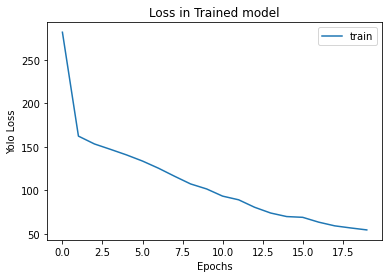

In [40]:
%matplotlib inline

plt.plot(trained_loss, label="train")
# plt.axhline(y=trained_loss_test, label="test", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Yolo Loss")
plt.title("Loss in Trained model")
plt.legend()
plt.show()

### (ii) Yolo Loss in test dataset
The loss in training set after 20 Epochs is 54.35 while the loss in test dataset is 134.84. It is worth noting that the train loss in the well-trained model is higher than the train loss in the over-fit model, which is reasonable. because over-fitting the model only leads to low train loss in small data and poor performance in the test set. The test loss here is consistent with my statement because it is much lower than the test loss of the overfitting model.

In [41]:
print("The loss in training set is {:.2f} while the loss in test set is {:.2f}".format(trained_loss[-1], trained_loss_test))

The loss in training set is 54.35 while the loss in test set is 134.84


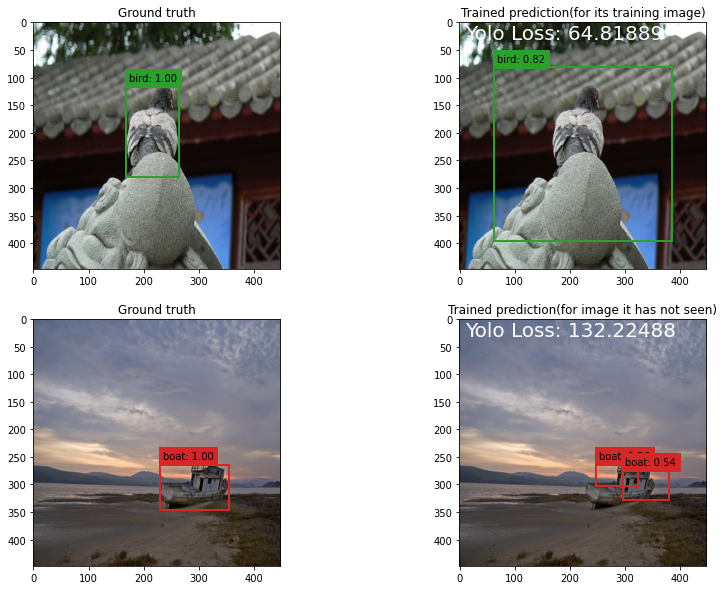

In [42]:
fig = plt.figure(figsize=(14,10))
for x, y in large_train_loader:
    for i in range(1):
        ax1 = fig.add_subplot(2,2,1)
        plt.title("Ground truth")
        x, y = x.to(DEVICE), y.to(DEVICE)
        bboxes = cellboxes_to_boxes(y)
        bboxes = non_max_suppression(bboxes[i], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        plot_image(x[i].permute(1,2,0).to("cpu"), bboxes, ax1)
        
        ax2 = fig.add_subplot(2,2,2)
        plt.title("Trained prediction(for its training image)")
        bboxes = cellboxes_to_boxes(trained_model(x))
        bboxes = non_max_suppression(bboxes[i], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        plot_image(x[i].permute(1,2,0).to("cpu"), bboxes, ax2)
    pred = trained_model(x)
    loss = loss_fn(pred, y)
    ax2.text(10, 30, 'Yolo Loss: {:.5f}'.format(loss.item()), fontsize=20, color='white')
    break


for x, y in test_loader:
    for i in range(1):
        ax3 = fig.add_subplot(2,2,3)
        plt.title("Ground truth")
        x, y = x.to(DEVICE), y.to(DEVICE)
        bboxes = cellboxes_to_boxes(y)
        bboxes = non_max_suppression(bboxes[i], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        plot_image(x[i].permute(1,2,0).to("cpu"), bboxes, ax3)
        
        ax4 = fig.add_subplot(2,2,4)
        plt.title("Trained prediction(for image it has not seen)")
        bboxes = cellboxes_to_boxes(trained_model(x))
        bboxes = non_max_suppression(bboxes[i], iou_threshold=0.5, threshold=0.3, box_format="midpoint")
        plot_image(x[i].permute(1,2,0).to("cpu"), bboxes, ax4)
    pred = trained_model(x)
    loss = loss_fn(pred, y)
    ax4.text(10, 30, 'Yolo Loss: {:.5f}'.format(loss.item()), fontsize=20, color='white')
    break

# 5. Discussion

Unfortunately, the result is not very good especially for the unseen image. But the fact is that Yolo's team trained the model in 3 weeks using GPUs to achieve a decent result. Also, using only 400 fully connected neurons reduces the performance of the model(They used 4096).

But our results also demonstrate the feasibility of Yolo. In the over-fitted model, we achieved almost identical results to the target, only the coordinates and size of bounding box have a slight error. In the well-trained model, the Yolo loss on seen image increased while the loss on unseen image decreased. My well-trained model recognizes the type of object in a dataset that has not seen it before, but there are some errors in the size and coordinates of the bounding box.

# Reference:
1. Most idea from Yolo's paper:

Redmon, J., Divvala, S., Girshick, R., & Farhadi, A. (2016). You only look once: Unified, real-time object detection. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 779-788).

2. The code from external library:

https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/object_detection/YOLO/utils.py

3. Full dataset can be retrieve from https://www.kaggle.com/datasets/aladdinpersson/pascal-voc-dataset-used-in-yolov3-video. The code for uploading the dataset from kaggle to colab can be found in the appendix.


4. Get a better understanding about Yolo after watch the video:

https://www.youtube.com/watch?v=n9_XyCGr-MI&list=PLhhyoLH6Ijfw0TpCTVTNk42NN08H6UvNq&index=6

5. Most picture from the project were taken from Yolo's paper or Internet.

# Appendix

## a. Download dataset from Kaggle into Google Colab
Here is all the code you need, if you want to upload the dataset(5GB) into google colab from kaggle

In [45]:
# # https://www.kaggle.com/general/74235  (Tutorial)

# ! pip install -q kaggle
# from google.colab import files
# files.upload()

In [46]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [47]:
# ! kaggle datasets download -d aladdinpersson/pascal-voc-dataset-used-in-yolov3-video

In [48]:
# ! unzip pascal-voc-dataset-used-in-yolov3-video.zip

## b. Some code to create .csv file

In [43]:
# import pandas as pd
# import numpy as np

# image_list = []
# text_list = []
# for i in range(6, 11):
#     i = str(i)
#     i = (6 - len(i))*'0' + i
#     image_list.append(i+'.jpg')
#     text_list.append(i+'.txt')

# example = {
#     'image':image_list,
#     'text' :text_list,
#           }
# df = pd.DataFrame(example)
# df.to_csv("data/5examples_test.csv", index=False)

## c. Create a training and test file wih random index

In [44]:
# import pandas as pd
# import numpy as np

# train_image_list = []
# train_text_list = []

# test_image_list = []
# test_text_list = []
# for i in range(1, 8000):
#     i = str(i)
#     i = (6 - len(i))*'0' + i
#     if np.random.uniform() < 0.95:
#         train_image_list.append(i+'.jpg')
#         train_text_list.append(i+'.txt')
#     else:
#         test_image_list.append(i+'.jpg')
#         test_text_list.append(i+'.txt')

# train_example = {
#             'image': train_image_list,
#             'text' : train_text_list,
#           }

# test_example = {
#             'image': test_image_list,
#             'text' : test_text_list,
#           }

# df = pd.DataFrame(train_example)
# df.to_csv("PASCAL_VOC/train.csv", index=False)

# df = pd.DataFrame(test_example)
# df.to_csv("PASCAL_VOC/test.csv", index=False)